# Check the results from smoothed spikes

In [1]:
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd

from param import *

sns.set_theme(style="whitegrid")
output_dir = ParamDir().output_dir
datalist = ParamDir().data_path_list

## Representatives
`window_size = 128, sigma = .32`

### coordinate

window_size:128, sigma: 0.32


Text(0.5, 0, 'time bins (1/3 sec)')

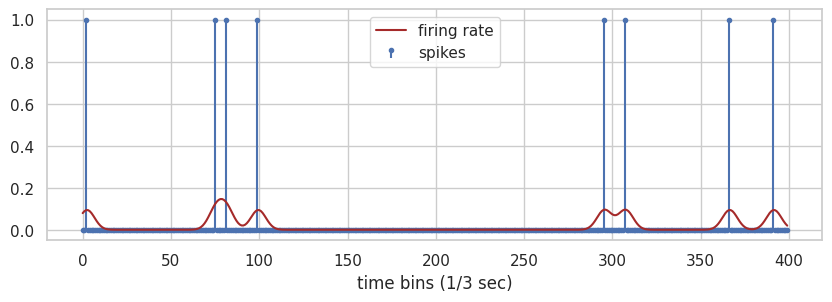

In [35]:
window_size = ParamFiringRateData().window_size_range[-2]
sigma = ParamFiringRateData().sigma_range[-2]
print(f"window_size:{window_size}, sigma: {sigma}")

from dataloader import BaseDataset
from util import gauss1d

data_dir = datalist[0]
dataset = BaseDataset(data_dir, 1.0, False)
spikes = dataset.spikes[:400, 0]
f = plt.figure(figsize = (10,3))
(markers, stemlines, baseline) = plt.stem(range(len(spikes)), spikes, label = "spikes", markerfmt=".")
plt.setp(baseline, visible=False)

kernel = gauss1d(np.linspace(-3, 3, window_size))
# xx = np.linspace(-3, 3, window_size)
# kernel = 1 / ((2 * np.pi) ** 2 * sigma) * np.exp(- (xx - 0) ** 2 / (2 * sigma ** 2))
def filtered(x)  :
    """Convovle with the given kernel."""
    return np.convolve(spikes, kernel, mode="same")
plt.plot(range(len(spikes)), np.apply_along_axis(filtered, 0, spikes), c = "brown", label = "firing rate")
plt.legend()
plt.xlabel("time bins (1/3 sec)")


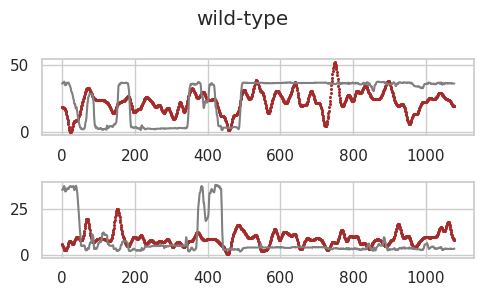

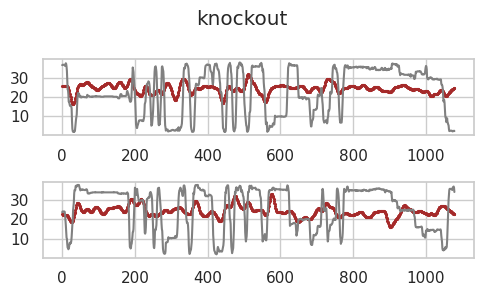

In [36]:
for m_id, data_dir in enumerate(datalist[[2, 1]]):
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "KO" in data_name else "wild-type"
    with open(output_dir/data_name/(f"rr_firing_rate_eval.pickle"),"rb") as f:
        eval_results_all = pickle.load(f)

    fig, axes = plt.subplots(nrows = 2, sharey='row', figsize=(5,3),tight_layout = True)

    for result in eval_results_all:
        if result["coord_axis"] == "x-axis" and result["sigma"] == sigma and result["window_size"] == window_size:
            # coordinate
            axes[0].plot(result["y_test"]/5, c = "gray", label="test")
            axes[0].scatter(np.arange(len(result["y_pred"])),result["y_pred"]/5, c = "brown", label="pred", s=1.5)
        if result["coord_axis"] == "y-axis" and result["sigma"] == sigma and result["window_size"] == window_size:
            # coordinate
            axes[1].plot(result["y_test"]/5, c = "gray", label="test")
            axes[1].scatter(np.arange(len(result["y_pred"])),result["y_pred"]/5, c = "brown", label="pred", s=1.5)
    plt.suptitle(mouse_type)

### fitted coefficient

## MSE for all mice

Text(0, 0.5, 'MSE(cm2)')

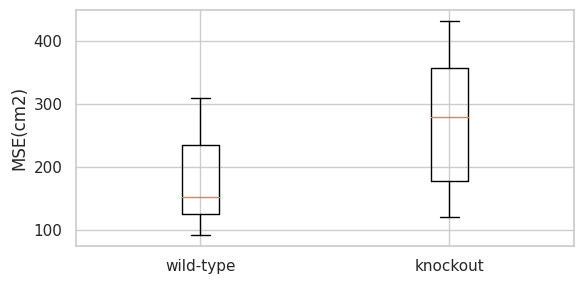

In [37]:
window_size = ParamFiringRateData().window_size_range[-1]
sigma = ParamFiringRateData().sigma_range[-2]

ko_mse_list = []
wt_mse_list = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    if "KO" in data_name:
        with open(output_dir/data_name/(f"rr_firing_rate_eval.pickle"),"rb") as f:
            eval_results_all = pickle.load(f)
        test_mse = [result["eval_test_scores"] for result in eval_results_all if ((result["coord_axis"] == "x-axis") and (result["sigma"] == sigma) and (result["window_size"] == window_size))][0]
        ko_mse_list .append(test_mse/25)

    else:
        with open(output_dir/data_name/(f"rr_firing_rate_eval.pickle"),"rb") as f:
            eval_results_all = pickle.load(f)
        test_mse = [result["eval_test_scores"] for result in eval_results_all if ((result["coord_axis"] == "x-axis") and (result["sigma"] == sigma) and (result["window_size"] == window_size))][0]
        wt_mse_list .append(test_mse/25)

fig, ax = plt.subplots(figsize=(6,3), tight_layout = True)
ax.boxplot([wt_mse_list, ko_mse_list])
ax.set_xticklabels(['wild-type', 'knockout'])
ax.set_ylabel("MSE(cm2)")

## Fitted Coeff for all mice

In [38]:
# fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(8,6), tight_layout = True)
conf_level = .01
# axes = axes.ravel()
window_size = ParamFiringRateData().window_size_range[-1]
sigma = ParamFiringRateData().sigma_range[-2]

KO_sig_ratio, WT_sig_ratio = [], []
for mouse_id, data_dir in enumerate(datalist):
    # ax = axes[mouse_id]
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "KO" in data_name else "wild-type"
    with open(output_dir/data_name/(f"rr_firing_rate_eval.pickle"),"rb") as f:
        eval_results_all = pickle.load(f)

    coord_axis, nthist= "x-axis", 1
    result = [result for result in eval_results_all if ((result["coord_axis"] == "x-axis") and (result["sigma"] == sigma) and (result["window_size"] == window_size))][0]

    # ax.plot(result["estimator"].fitted_param, label = f"nthist:", c="gray")

    # labels = ax.get_xticks().tolist()
    xx = np.arange(len(result["estimator"].fitted_param))
    pass_p = 0
    for ii, p_value in enumerate(result['sig_tests'].t_p_value_list):
        if (p_value < conf_level) or (p_value > 1 - conf_level):
            pass_p += 1
            # ax.scatter(xx[ii], result["estimator"].fitted_param[ii], c="brown", s=10)
    # labels = [''] * len(result["estimator"].fitted_param)
    # labels[0],labels[int(len(labels)/2)] ,labels[-1] = "intercept", "neurons", "past-coord"
    # ax.set_xticks(xx, labels)
    # ax.set_title(f"{mouse_type}:{pass_p/len(xx):.1f}")

    if mouse_type == "knockout": KO_sig_ratio.append(pass_p/len(xx))
    else: WT_sig_ratio.append(pass_p/len(xx))

# plt.suptitle(f"confidence level:{conf_level}")

Text(0, 0.5, 'ratio')

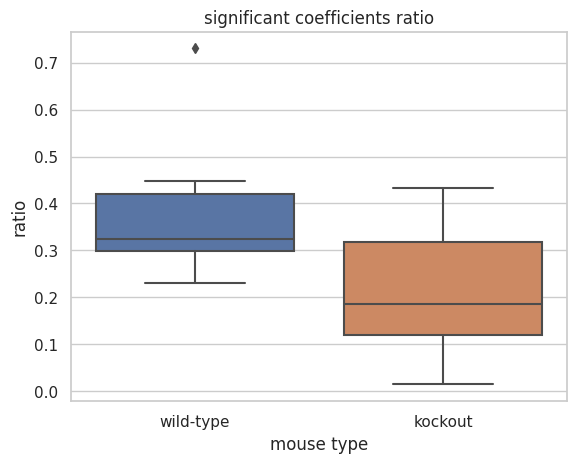

In [40]:
sns.boxplot([WT_sig_ratio, KO_sig_ratio])
plt.xticks([0,1], ["wild-type", "kockout"])
plt.title("significant coefficients ratio")
plt.xlabel("mouse type")
plt.ylabel("ratio")